In [33]:
import datetime as dt
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf

In [35]:
spy_ssga_url = "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx"
tickers = list(pd.read_excel(spy_ssga_url, header=4).dropna().Ticker)

In [36]:
data = yf.download(tickers, period="10y")[["Adj Close", "Volume"]]

[*********************100%***********************]  505 of 505 completed

3 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- CASH_USD: No data found, symbol may be delisted


In [37]:
close = data["Adj Close"]
volume = data["Volume"]

In [38]:
class Momentum_Factors():
    
    def __init__(self, close, volume):
        self.tickers = tickers
        self.close = data["Adj Close"]
        self.price = data["Adj Close"]
        self.returns = data["Adj Close"].pct_change()
        self.volume = data["Volume"]
    
    
    def percent_above(self):
        """ Returns the percent above the 52 week low """
        self.roll_min = self.price.rolling(252).min()
        return ((self.price - self.roll_min) / self.roll_min)[-20:].mean()
    
    
    def price_oscillator(self):
        """ Returns the price oscillation """
        return ((self.price.rolling(20).mean() - self.price.rolling(260).mean())/
               self.price.rolling(260).std())[-20:].mean()
    
    
    def week_39_return(self):
        """ Returns: 39 Week Return """
        return self.price.pct_change(189)[-20:].mean()
    
    
    def trend(self):
        """ Returns the trend of the tickers """
        self.trend_df = pd.DataFrame(index=self.tickers)
        
        for i in range(1, 21):
            self.trend_df[i] = np.polyfit(range(len(self.price[-i - 252: -i])),
                                         self.price[-i - 252: -i], 1)[0]
        return self.trend_df.mean(axis=1)
    
    
    def price_volume(self):
        """ Returns volume price trend """
        return (self.returns * self.volume).rolling(252).sum()[-20:].mean()
    
    
    def merged_dataframe(self):
        """ Returns dataframe of the factors above """
        self.momentum_factor = pd.DataFrame(index=self.tickers)
        
        self.momentum_factor["Percent Above"] = self.percent_above()
        self.momentum_factor["Price Oscillator"] = self.price_oscillator()
        self.momentum_factor["39 Week Return"] = self.week_39_return()
        self.momentum_factor["Trend"] = self.trend()
        self.momentum_factor["Price Volume"] = self.price_volume()
        
        return (self.momentum_factor - self.momentum_factor.mean())/ self.momentum_factor.std()
    
    
    def baskets(self):
        """ Returns monthly z-factor score """
        self.z_score = self.merged_dataframe().sum(axis=1)
        return self.z_score.nlargest(10).index, self.z_score.nsmallest(10).index

In [39]:
dates = pd.DataFrame(pd.date_range("2017-08-3",
                                   end=dt.datetime.today(),
                                   freq='M'))

dates.rename(columns={0:"dates"}, inplace=True)

In [40]:
portfolio = pd.DataFrame(index=dates.dates, columns=tickers)
long_basket = pd.DataFrame(index=dates.dates, columns=tickers)
short_basket = pd.DataFrame(index=dates.dates, columns=tickers)

In [43]:
for date in dates.dates:
    factors = Momentum_Factors(close, volume)
    longs, shorts = factors.baskets()
    
    for long in longs:
        portfolio[long].iloc[portfolio.index == date] = '1'
        long_basket[long].iloc[long_basket.index == date] =  '1'
        
    for short in shorts:
        portfolio[short].iloc[portfolio.index == date] = '-1'
        short_basket[short].iloc[short_basket.index == date] = '-1'
        
        
portfolio.fillna('0', inplace=True)
long_basket.fillna('0', inplace=True)
short_basket.fillna('0', inplace=True)

In [44]:
#Assets to go long
longs

Index(['OXY', 'DVN', 'DLTR', 'MRO', 'CF', 'NLSN', 'XOM', 'CTRA', 'APA',
       'ENPH'],
      dtype='object')

In [45]:
#Assets to go short
shorts

Index(['HPE', 'META', 'NFLX', 'PYPL', 'CCL', 'MU', 'AMZN', 'BKNG', 'INTC',
       'CMG'],
      dtype='object')

In [46]:
#Monthly returns

monthly_returns = data["Adj Close"][:-20].pct_change().resample('m').sum()#.shift(-1))
monthly_returns.head(10)

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-08-31,-0.049760,-0.001796,0.030478,0.071879,0.000000,-0.013991,0.003119,-0.012427,0.016302,-0.025800,...,0.055961,-0.048247,0.004975,-0.033860,0.011649,-0.054554,0.033415,0.045448,0.024034,0.000000
2012-09-30,0.038568,-0.006694,-0.036532,0.004780,0.000000,0.005986,-0.051644,0.045816,0.132072,0.039472,...,0.114586,0.003757,0.047126,0.052392,0.037132,0.041653,0.094037,0.006040,0.072938,0.000000
2012-10-31,-0.064220,0.158821,0.038109,-0.110185,0.000000,0.019313,-0.053211,-0.035488,-0.025783,0.048840,...,0.051448,0.019745,-0.002437,-0.033052,-0.030052,0.064698,-0.049291,-0.041082,0.041098,0.000000
2012-11-30,0.065671,0.062127,0.042555,-0.006619,0.000000,0.074822,-0.327983,-0.006853,0.009402,0.018189,...,-0.003905,-0.042537,-0.026377,0.077143,0.075478,-0.037007,0.027941,0.083578,-0.063576,0.000000
2012-12-31,0.072004,0.051025,-0.009510,-0.089375,0.000000,0.023185,0.014188,0.008363,-0.019781,0.087449,...,0.002528,-0.001866,-0.017326,-0.000228,0.039484,-0.007798,0.014115,0.010372,0.065874,0.000000
2013-01-31,0.091155,0.063113,0.016873,-0.143093,0.058435,0.050138,0.042542,0.080754,0.079080,0.004766,...,0.108975,0.039928,0.039485,0.053891,0.031046,-0.015068,0.113382,0.098028,0.087980,0.000000
2013-02-28,-0.073867,-0.053779,0.040496,-0.022973,0.008459,0.044960,0.148265,-0.002085,0.034955,0.039715,...,-0.058444,0.032903,0.002194,-0.006505,-0.009173,0.010266,0.005656,0.033780,0.037044,0.078492
2013-03-31,0.015789,0.237724,0.081231,0.005685,0.101330,0.087525,0.155827,0.045802,0.022750,0.103698,...,0.069050,0.044078,0.006589,0.026762,0.004529,0.094766,0.007139,0.053246,0.034920,0.001243
2013-04-30,-0.009127,0.002610,0.017030,0.005042,0.134957,0.052319,-0.003280,0.049651,0.082675,0.036120,...,0.096312,0.068849,-0.011613,-0.000338,0.009345,-0.045075,0.017450,-0.008444,-0.012689,-0.005120


In [47]:
#Multiplying the portfolio, long_basket, short basket data frames with the monthly returns

portfolio_returns = pd.DataFrame((monthly_returns * portfolio.astype(int)).mean(axis=1)).dropna()
short_returns = pd.DataFrame((monthly_returns * short_basket.astype(int)).mean(axis=1)).dropna()
long_returns = pd.DataFrame((monthly_returns * long_basket.astype(int)).mean(axis=1)).dropna()

#Monthly return of etf
etf_returns = pd.DataFrame(monthly_returns[monthly_returns.index >= "2017-08-3"].mean(axis=1))


#Difference in monthly return of our portfolio to the etf
portfolio_diff = pd.DataFrame(portfolio_returns[0] - etf_returns[0]).dropna()
short_diff = pd.DataFrame(short_returns[0] - etf_returns[0]).dropna()
long_diff = pd.DataFrame(long_returns[0] - etf_returns[0]).dropna()

In [48]:
#Cumulative returns of portfolio, short and long basket

portfolio_returns['cumulative_return'] = np.exp(np.log1p(portfolio_returns).cumsum())
short_returns['cumulative_return'] = np.exp(np.log1p(short_returns).cumsum())
long_returns['cumulative_return'] = np.exp(np.log1p(long_returns).cumsum())

#cum return of etf
etf_returns['cumulative_return'] = np.exp(np.log1p(etf_returns.mean(axis=1)).cumsum())

In [49]:
#Outputs:

#Momentum Factors
factors.merged_dataframe()

,Percent Above,Price Oscillator,39 Week Return,Trend,Price Volume
AAPL,-0.026147,-0.010196,0.644960,-0.227819,-0.084128
MSFT,-0.497744,-0.568096,-0.237032,0.242050,-0.487838
AMZN,0.021361,-0.813567,-0.877067,0.074593,-5.644182
TSLA,0.424312,-0.031764,-0.226851,0.333661,1.614988
GOOGL,-0.616188,-0.767485,-0.533503,0.881538,-0.517368
...,...,...,...,...,...
DISH,-0.524316,-0.911362,-2.334836,0.157524,-0.762457
PVH,-0.543202,-0.870319,-1.712832,-0.068448,-0.060668
CASH_USD,NaN,NaN,NaN,-2.814926,NaN
NWS,-0.544281,-1.222255,-0.968857,0.292287,0.066389


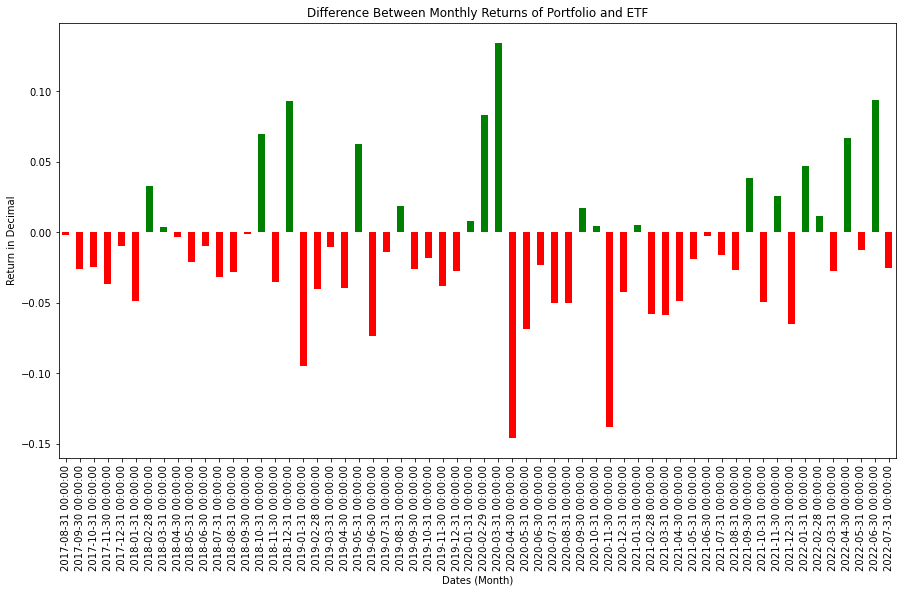

In [50]:
#Plotting returns of the trading algorithm

portfolio_diff['colors'] = (portfolio_diff[0] > 0)  #Colors for the postivie 
                                                #and negative values of return

portfolio_diff[0].plot(kind='bar'
                   , figsize=(15,8)
                   , title='Difference Between Monthly Returns of Portfolio and ETF'
                   , xlabel='Dates (Month)'
                   , ylabel='Return in Decimal'
                   , color=['green' if i == True else 'red' for i in portfolio_diff['colors']]);

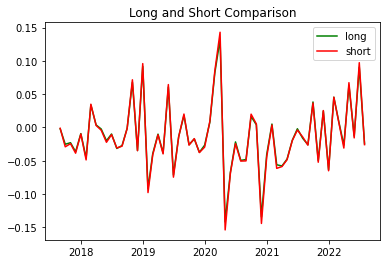

In [51]:
#Comparing the long and short assets and plotting their returns

plt.plot(long_diff,
        color="g",
        label="long")

plt.plot(short_diff,
        color="r",
        label="short")

plt.legend()
plt.title('Long and Short Comparison');

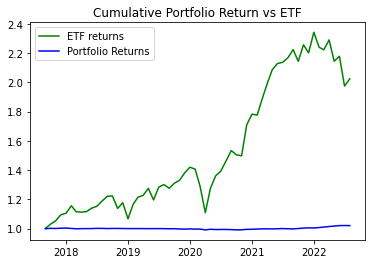

In [52]:
#Plotting the cumulative portfolio return vs the cumulative ETF return

plt.plot(etf_returns["cumulative_return"],
         label="ETF returns",
        color="g")

plt.plot(portfolio_returns["cumulative_return"],
         label="Portfolio Returns",
        color="b")

plt.legend()
plt.title('Cumulative Portfolio Return vs ETF');

In [ ]:
# the code for this project has been borrowed from the handsome Professor John Droescher and Victor Essien on Github